## **Анализ результатов A/B-тестирования**


Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

from pprint import pprint
from typing import NamedTuple

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [97]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.** Информация о Датафрейме

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.** Работа с признаком "date"

Приведем столбец date к типу данных datetime. Убедимся в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируем данные по признаку группы и определим первую и последнюю дату наблюдения для каждой из групп.


In [99]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%M-%d').dt.date
date = data.groupby('group')['date'].agg(['min', 'max']).reset_index()
date['delta'] = (date['max'] - date['min'])
display(date)

,group,min,max,delta
0,A,2021-01-02,2021-01-24,22 days
1,B,2021-01-02,2021-01-24,22 days


##### Вывод:
Промежутки проведения тестирования равны

## **Задание 7.3.** Количество посещений, покупок и сумма покупок разделенных по группам А и В

In [100]:
sum_table1_info = data.groupby(by='group').agg(
    coutn_visits=('user_id', 'count'),
    coutn_purchases=('purchase', 'sum'),
    sum_price=('price', 'sum')
).reset_index()

sum_table1_info['sum_price'] = round(sum_table1_info['sum_price'] / 1e6, 2)
delta_coutn_visits = round((sum_table1_info.iloc[1,1] / sum_table1_info.iloc[0,1] - 1) * 100, 2)
delta_coutn_purchases = round((sum_table1_info.iloc[1,2] / sum_table1_info.iloc[0,2] - 1) * 100, 2)
delta_sum_price = round((sum_table1_info.iloc[1,3] / sum_table1_info.iloc[0,3] - 1) * 100, 2)
sum_table1_info.loc['delta, %'] = [ '',delta_coutn_visits, delta_coutn_purchases, delta_sum_price]
sum_table1_info

,group,coutn_visits,coutn_purchases,sum_price
0,A,147202.00,17723.00,1436.26
1,B,147276.00,17514.00,1554.10
"delta, %",,0.05,-1.18,8.20


## **Задание 7.4.** Проверка, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы.

In [101]:
group_a = data[data['group'] == 'A']['user_id']
group_b = data[data['group'] == 'B']['user_id']
user_intersection = set(group_a).intersection(set(group_b))
print(f'Количество пользователей попавших в обе группы: {len(user_intersection)}')

Количество пользователей попавших в обе группы: 1895


### **Исключиаем пользователей, оказавшихся в обеих группах**

In [102]:
# updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)].copy()
updated_data = data[~data['user_id'].isin(user_intersection)].copy()

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.** Количество посещений, покупок и сумма покупок разделенных по группам А и В, исключая пользователей попавших в обе группы.

In [103]:
up_sum_table = updated_data.groupby(by='group').agg(
    coutn_visits=('user_id', 'count'),
    coutn_purchases=('purchase', 'sum'),
    sum_price=('price', 'sum')
).reset_index()
sum_table2_info = up_sum_table.copy()
sum_table2_info['sum_price'] = round(sum_table2_info['sum_price'] / 1e6, 2)

delta_coutn_visits = round((sum_table2_info.iloc[1,1] / sum_table2_info.iloc[0,1] - 1) * 100, 2)
delta_coutn_purchases = round((sum_table2_info.iloc[1,2] / sum_table2_info.iloc[0,2] - 1) * 100, 2)
delta_sum_price = round((sum_table2_info.iloc[1,3] / sum_table2_info.iloc[0,3] - 1) * 100, 2)
sum_table2_info.loc['delta, %'] = [ '',delta_coutn_visits, delta_coutn_purchases, delta_sum_price]

print('Таблица до удаления пересекающихся пользователей:')
display(sum_table1_info)
print('Таблица после очистки:')
display(sum_table2_info)

Таблица до удаления пересекающихся пользователей:


,group,coutn_visits,coutn_purchases,sum_price
0,A,147202.00,17723.00,1436.26
1,B,147276.00,17514.00,1554.10
"delta, %",,0.05,-1.18,8.20


Таблица после очистки:


,group,coutn_visits,coutn_purchases,sum_price
0,A,145307.00,17487.00,1417.78
1,B,145381.00,17290.00,1533.01
"delta, %",,0.05,-1.13,8.13


Выводы:
    
1. После удаления юзеров, которые попали в обе группы, и получили сбалансированные группы пользователей учавствующих в А/В тестировании. Группы практичестки равны по количеству пользователей.

2. Количество пользователей достаточно велико. Что бы продолжить тест дальше.

3. Сумарное количество покупок В-варианта сократилось на 1%, однако сумма всех покупок В-варианта больше на 8%

## **Задание 7.6.** Конверсия и средний чек в группах.

In [104]:
up_sum_table['conversion'] = round((up_sum_table['coutn_purchases'] / up_sum_table['coutn_visits']) * 100, 2)
up_sum_table['mean_check'] = (round(up_sum_table['sum_price'] / up_sum_table['coutn_purchases'])).astype(int)
up_sum_table

,group,coutn_visits,coutn_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076
1,B,145381,17290,1533010000,11.89,88665


#### Вывод:
Вариант А Эффективнее по конверсии, в то время как вариант В эфективнее по среднему чеку.

## **Задание 7.7.** Сводная таблица зависимоти продаж от группы и цены тура.

In [105]:
df = pd.DataFrame.from_dict({'Таиланд': [100000],
'Турция': [60000],
'Мальдивы': [200000],
'Санкт-Петербург': [10000],
'Камчатка': [150000]}, orient='index', columns=['price']).reset_index().rename(columns={'index':'tour'})
df

,tour,price
0,Таиланд,100000
1,Турция,60000
2,Мальдивы,200000
3,Санкт-Петербург,10000
4,Камчатка,150000


In [119]:
merged_df = pd.merge(updated_data, df, how='left', on='price')
pivot_table = merged_df.pivot_table(values='user_id', index=['tour', 'price'], columns='group', aggfunc='count')
pivot_table.sort_values(by='price')

,group,A,B
tour,price,,
Санкт-Петербург,10000,5182,5201
Турция,60000,5271,1730
Таиланд,100000,1832,5227
Камчатка,150000,3478,3438
Мальдивы,200000,1724,1694


## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

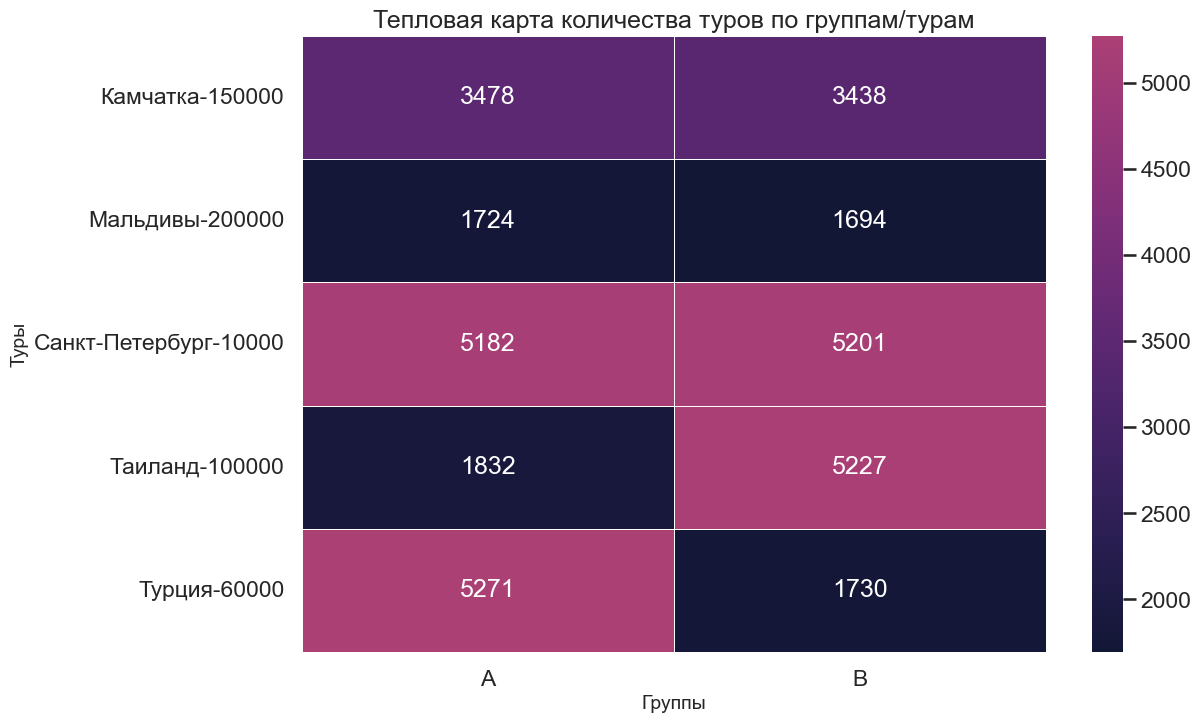

In [107]:
cmap = sns.cubehelix_palette(start=2.7, rot=0.8, hue=1.3, dark=0.1, light=.4, reverse=True, as_cmap=True)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 8))
sns.heatmap(
    data=pivot_table,
    cmap=cmap,#'flare', 
    annot=True, 
    fmt='', 
    linewidths=.5,
    cbar=True
)
axes.set_title('Тепловая карта количества туров по группам/турам',fontsize=18)
axes.set_xlabel(xlabel='Группы', fontsize=14)
axes.set_ylabel(ylabel='Туры', fontsize=14)
plt.show()


Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

#### Вывод:
Сразу разница по количеству туров в Тайланд и Турцию. В группе А акцент смещен к турам в Турцию, а в группе В - к турма в Тайланд. Туры в Тайланд дороже туров в Турцию, Это 100 тыс. и 60 тыс. соответственно. Так как по остальным турам разница несущественна, то причина почему средней чек в группе В выше, в предпочтении туров в Тайланд турам в Турцию.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [108]:
table_cumsum = updated_data.groupby(['date', 'group']).agg(
    coutn_visits=('user_id', 'count'),
    coutn_purchases=('purchase', 'sum'),
    sum_price=('price', 'sum')
).reset_index()
# daily conversion	mean_check

table_cumsum['daily_conversion'] = round((table_cumsum['coutn_purchases'] / table_cumsum['coutn_visits']) * 100, 2)
table_cumsum['daily_mean_check'] = (round(table_cumsum['sum_price'] / table_cumsum['coutn_purchases'])).astype(int)
table_cumsum[table_cumsum['date'] == pd.to_datetime('2021-01-03').date()]


,date,group,coutn_visits,coutn_purchases,sum_price,daily_conversion,daily_mean_check
2,2021-01-03,A,6596,748,62000000,11.34,82888
3,2021-01-03,B,6619,754,65960000,11.39,87480


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [109]:
# Комулятивные количество посещений/количество покупок/суммы покупок
table_cumsum['cum_count_visit'] = table_cumsum.groupby('group')['coutn_visits'].cumsum()
table_cumsum['cum_coutn_purchases'] = table_cumsum.groupby('group')['coutn_purchases'].cumsum()
table_cumsum['cum_sum_price'] = table_cumsum.groupby('group')['sum_price'].cumsum()

# Комулятивные дневная конверсия/средний чек
table_cumsum['cum_daily_conversion'] = round((table_cumsum['cum_coutn_purchases'] / table_cumsum['cum_count_visit']) * 100, 2)
table_cumsum['cum_daily_mean_check'] = (round(table_cumsum['cum_sum_price'] / table_cumsum['cum_coutn_purchases'])).astype(int)

display(table_cumsum.loc[table_cumsum['date'] == pd.to_datetime('2021-01-20').date(), ['group','cum_daily_conversion']])
display(table_cumsum.loc[table_cumsum['date'] == pd.to_datetime('2021-01-12').date(), ['group','cum_daily_mean_check']])

,group,cum_daily_conversion
36,A,11.98
37,B,11.90


,group,cum_daily_mean_check
20,A,81492
21,B,88352


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

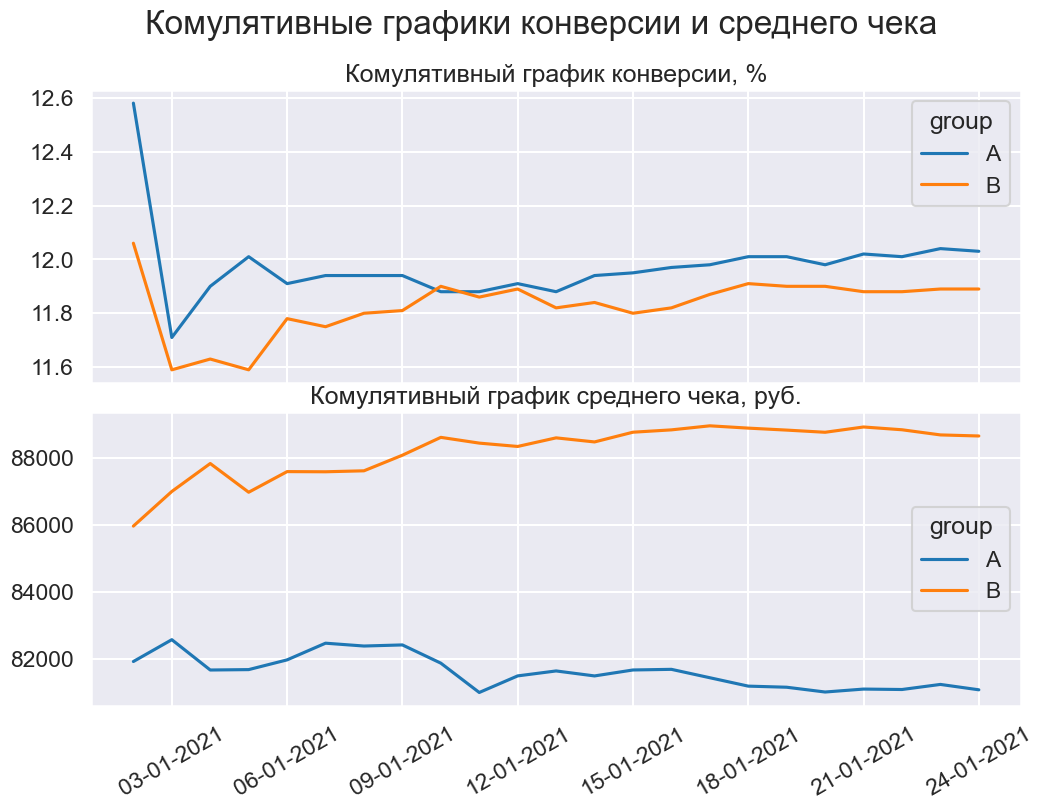

In [110]:
# Выбираем стиль графика
sns.reset_orig()
sns.set_style("darkgrid")
sns.set_context("talk")

# Создаем фигуру с двумя графиками
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
# Создаем верхний график с кумулятивной конверсией по дням
sns.lineplot(
    data=table_cumsum,  # Используем данные из таблицы table_cumsum
    x='date',  # Ось x - дата
    y='cum_daily_conversion',  # Ось y - кумулятивная конверсия
    hue='group',  # Разделяем данные по группам
    ax=axes[0]  # Размещаем график на первой (верхней) панели
)

# Создаем нижний график с кумулятивным средним чеком по дням
sns.lineplot(
    data=table_cumsum,  # Используем данные из таблицы table_cumsum
    x='date',  # Ось x - дата
    y='cum_daily_mean_check',  # Ось y - кумулятивный средний чек
    hue='group',  # Разделяем данные по группам
    ax=axes[1]  # Размещаем график на второй (нижней) панели
)

# Добавляем общий заголовок для графиков
fig.suptitle('Комулятивные графики конверсии и среднего чека', fontsize=24)

# Добавляем название верхнего графика и убираем подписи его осей
axes[0].set_title('Комулятивный график конверсии, %')
axes[0].set_ylabel('')          # Убираем название по оси у
axes[0].set_xlabel('')          # Убираем название по оси х
axes[0].set_xticklabels([])     # Убираем название делений по оси х

# Уменьшаем расстояние между графиками
plt.subplots_adjust(hspace=0.1)

# Добавляем название нижнего графика и убираем подписи его осей
axes[1].set_title('Комулятивный график среднего чека, руб.')
axes[1].set_ylabel('')      # Убираем название по оси у
axes[1].set_xlabel('')      # Убираем название по оси х

# Корректируем шаг деления для лучшей читаемости
axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=3))      # Задаем шаг в 3 дня
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(2000))       # Задаем шак 2000 единиц
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=3))      # Задаем шаг в 3 дня
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y')) # Задаем формат даты

# Поворачиваем подписи дат для лучшей читаемости
axes[1].tick_params(axis='x', rotation=30)

# Отображаем графики
plt.show()

#### Вывод:
По графикам видно, что в варианте А комулятивная конверсия незначительно но выше, однако в варианте В комулятивный средне-дневной чек значительно выше, чем в варианте А

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

In [111]:
converted_piv_sample= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv_sample)

,sum,count
group,,
A,17487,145307
B,17290,145381


In [112]:
"""
    Для проверки гипотезы равенства пропорций мы можем воспользоваться
    уже знакомым нам z-критерием для пропорций. 
""";
converted_piv_sample= updated_data.groupby('group',)['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv_sample)


# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
z_stat, p_value = proportions_ztest(
    count=converted_piv_sample['sum'], #число "успехов"
    nobs=converted_piv_sample['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

,sum,count
group,,
A,17487,145307
B,17290,145381


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


#### Вывод:
Значение p_value равное 0.12, означает, что мы не можем отвергнуть нулевую гипотезу о том, что две коверсии равны. Это означает, что различия между двумя выборками не являются статистически значимыми на уровне значимости 0.05.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов.
 Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

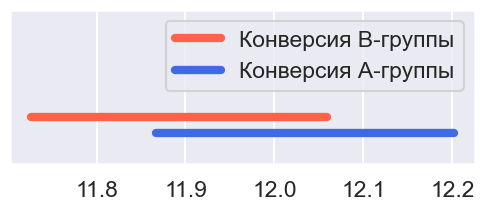

Доверительный интервал для первой выборки: [11.87, 12.20]
Доверительный интервал для второй выборки: [11.73, 12.06]


In [113]:
class confidence_interval(NamedTuple):
    lower: float
    upper: float

def proportions_conf_interval(n: int, p: float, gamma: float=0.95) -> confidence_interval:
    """
        Нахождение доверительного интервала для истинной пропорции
        n: размер выборки для группы
        p: пропорция(коверсия) в группе
    """
    import numpy as np
    
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * np.sqrt(p * (1 - p) / n) #погрешность
    lower_bound, upper_bound = p + np.array([-1, 1]) * eps # нижняя и верхняя границы
    return confidence_interval(lower_bound*100, upper_bound*100)

conf_interval_a = proportions_conf_interval(
    n=updated_data[updated_data['group'] == 'A']['user_id'].count(), # размер выборки
    p=updated_data[updated_data['group'] == 'A']['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
    n=updated_data[updated_data['group'] == 'B']['user_id'].count(), # размер выборки
    p=updated_data[updated_data['group'] == 'B']['purchase'].mean() # выборочная пропорция
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2))
sns.lineplot(y=1, x=conf_interval_b, linewidth=6, label='Конверсия В-группы', ax=ax, color='tomato')
sns.lineplot(y=-1, x=conf_interval_a, linewidth=6, label='Конверсия А-группы', ax=ax, color='royalblue')
plt.ylim(-5,15)
plt.yticks(visible=False)
plt.grid(axis='y', visible=False)
plt.legend()
plt.show()

# вывод результатов
print(f"Доверительный интервал для первой выборки: [{conf_interval_a.lower:.2f}, {conf_interval_a.upper:.2f}]")
print(f"Доверительный интервал для второй выборки: [{conf_interval_b.lower:.2f}, {conf_interval_b.upper:.2f}]")

In [114]:
class proportion_and_sampling(NamedTuple):
    A: int | float
    B: int | float

def diff_proportions_conf_interval(n: proportion_and_sampling, 
                                   p: proportion_and_sampling, 
                                   gamma: float=0.975
                                ) -> confidence_interval:
    import numpy as np
    
    # разность выборочных долей
    p_diff = p.B - p.A
    
    # стандартная ошибка разности выборочных долей
    se_diff = np.sqrt(p.A*(1-p.A)/n.A + p.B*(1-p.B)/n.B)
    
    # критическое значение стандартного нормального распределения для уровня доверия 95%
    z_crit = norm.ppf(gamma)
    
    # расчет доверительного интервала
    lower, upper = p_diff + np.array([-1, 1]) * z_crit * se_diff
    
    return confidence_interval(lower*100, upper*100)
    

sampling = proportion_and_sampling(*(updated_data.groupby('group')['user_id'].count()))
proportion = proportion_and_sampling(*(updated_data.groupby('group')['purchase'].mean()))

result = diff_proportions_conf_interval(sampling, proportion)

# вывод результатов
print(f"Доверительный интервал для разности конверсий: [{result.lower:.2f}, {result.upper:.2f}]")

Доверительный интервал для разности конверсий: [-0.38, 0.09]


##### Вывод
Интервалы двух конверсий пересекается, это означает, что мы не можем с уверенностью сказать, что одна конверсия лучше или хуже, чем другая. В этом случае мы не можем сделать вывод о том, что одна конверсия значимо отличается от другой.

Так как доверительный интервал для разности конверсий пересекает ноль, это означает, что мы не можем с уверенностью сказать, что разница между конверсиями значима. В этом случае мы не можем сделать вывод о том, что одна конверсия лучше или хуже, чем другая.

## **Задание 7.12.**    Проверка нормальности ежедневного среднего чека

In [115]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(table_cumsum[table_cumsum['group']=='A']['daily_mean_check'])
shapiro_result_b = shapiro(table_cumsum[table_cumsum['group']=='B']['daily_mean_check'])
print(f'p-value группы А {round(shapiro_result_a.pvalue, 2):.02f}')
print(f'p-value группы B {round(shapiro_result_b.pvalue, 2):.02f}')
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f"Принимаем альтернативную гипотезу. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")    

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.** Проведение T-теста

In [116]:
# нулевая и альтернативная гипотезы
H0 = 'Равенство ежедневных средних чеков в группах'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05 # уровень значимости
# вычисляем результат Т-теста для выборок
results = ttest_ind(
    a=table_cumsum[table_cumsum['group']=='A']['daily_mean_check'],
    b=table_cumsum[table_cumsum['group']=='B']['daily_mean_check'], 
    alternative='less'
)

# выводим результат на экран
print(f'p-value: {results.pvalue:.2f}')
# сравниваем полученное p-value с уровнем значимости
if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу и принимаем альтернативную гипотезу.")
    print(H1)
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value: 0.00
Отвергаем нулевую гипотезу и принимаем альтернативную гипотезу.
Ежедневный средний чек в группе А меньше, чем в группе B


##### Вывод: 
Так как статистический тест `ttest_ind` показал pvalue меньше уровня значимости 0.05, то можно сделать вывод о том, что существует статистически значимая разница между средними чеками в группах A и B. Это означает, что вероятность получить такую разницу случайно мала и, скорее всего, различия между группами действительно существуют.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

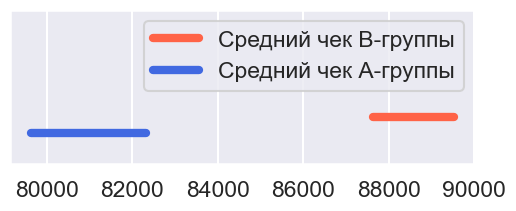

Доверительный интервал дневного среднего чека для группы А: [79630, 82308]
Доверительный интервал дневного среднего чека для группы В: [87626, 89526]


In [117]:

def conf_interval(df: pd.Series, gamma: float=0.95) -> confidence_interval:
    n = df.shape[0] # // df.count() # размер выборки
    k = n - 1                       # число степеней свободы
    x_mean = df.mean()              # выборочное среднее
    x_std = np.std(df, ddof=1)      # выборочное стандартное отклонение
    alpha = 1 - gamma               # уровень значимости

    # Критическое значение t-распределения
    t_crit = -t.ppf(alpha/2, k)
    
    # Погрешность
    eps = t_crit * x_std / np.sqrt(n)
    # Доверительный интервал
    lower_bound, upper_bound = x_mean + np.array([-1, 1]) * eps
    
    return confidence_interval(lower_bound, upper_bound)


conf_interval_a = conf_interval(table_cumsum[table_cumsum['group']=='A']['daily_mean_check'])
conf_interval_b = conf_interval(table_cumsum[table_cumsum['group']=='B']['daily_mean_check'])


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2))
sns.lineplot(y=1, x=conf_interval_b, linewidth=6, label='Средний чек В-группы', ax=ax, color='tomato')
sns.lineplot(y=-1, x=conf_interval_a, linewidth=6, label='Средний чек А-группы', ax=ax, color='royalblue')
plt.ylim(-5,15)
plt.yticks(visible=False)
plt.grid(axis='y', visible=False)
plt.legend()
plt.show()

# вывод результатов
print(f"Доверительный интервал дневного среднего чека для группы А: \
[{conf_interval_a.lower:.0f}, {conf_interval_a.upper:.0f}]")
print(f"Доверительный интервал дневного среднего чека для группы В: \
[{conf_interval_b.lower:.0f}, {conf_interval_b.upper:.0f}]")

Пересечения между доверительными интервалами не наблюдается, что может указывать на статистически значимые различия между средними чеками в группах А и В.
Значения доверительного интервала в группе В выше, чем в группе А

## Общий вывод

Из проведенных тестов стало ясно, что разница в конверсиях является статичтически на важной, на уровне значимости 0.05. Также, мы не можем сделать вывод о том, что одна конверсия лучше или хуже, чем другая, так как интервалы доверительных интервалов конверсий пересекаются.

С другой стороны, статистический тест показал, что существует статистически значимая разница между средними чеками в группах A и B. Это означает, что вероятность получить такую разницу случайно мала и, скорее всего, различия между группами действительно существуют. Это может быть связано с тем, что в группе А был смещен акцент на туры в Турцию, а в группе В - на туры в Тайланд, которые являются более дорогими.

Таким образом, мы можем заключить, что вариант В оказался более эффективным по среднему чеку/